# Deep Learning
# Laboratorio 6 - Recomenadaciones basadas en contenido

## Integrantes:
* Andres de la Roca
* Jun Woo Lee

Un sistema de recomendacion basado en contenido es un sistema que recomienda items similares a los que un usuario ha consumido en el pasado o ciertos parametros dentro del perfil del usuario que se puedan utilizar para realizar una recomendacion. Este tipo de sistemas de recomendacion se basan exclusivamente en el contenido de los items analizados y los compara con el perfil del usuario para generar sus recomendaciones.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [14]:
df_ratings = pd.read_csv('./data/Ratings.csv')
df_users = pd.read_csv('./data/Users.csv')
df_books = pd.read_csv('./data/Books.csv')

C:\Users\Andre\AppData\Local\Temp\ipykernel_18964\3162812482.py:3: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [15]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [16]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [17]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [18]:
df_books = df_books[~df_books['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard'])]
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'])

C:\Users\Andre\AppData\Local\Temp\ipykernel_18964\3565748955.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



* Dataset Ratings:
  * User-ID: User ID
  * ISBN: ISBN number
  * Book-Rating: Rating of book given by user  


<br>

* Dataset Users:
  * User-ID: User ID
  * Location: Location of user
  * Age: Age of user  

<br>
  
  
* Dataset Books:
  * ISBN: ISBN number
  * Book-Title: Book title
  * Book-Author: Book author
  * Year-Of-Publication: Year of publication
  * Publisher: Publisher of book
  * Image-URL-S: URL of image cover small
  * Image-URL-M: URL of image cover medium
  * Image-URL-L: URL of image cover large

## EDA

In [19]:
def plot_distribution(feature, data):
    sns.displot(x=feature, data=data, kde=True, color='green')
    plt.figtext(0.2, 1, '%s Distribution'%feature, fontfamily='serif', fontsize=20, fontweight='bold')

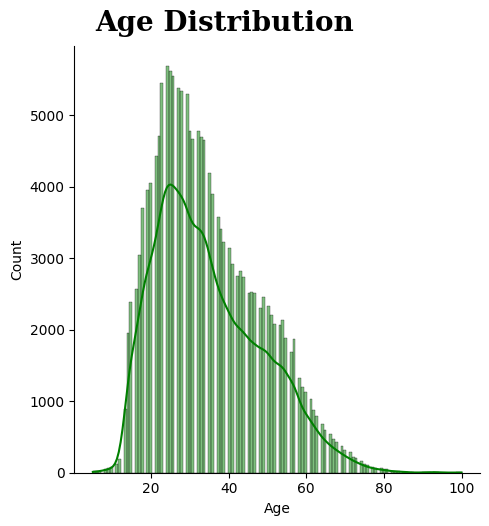

In [20]:
df_users = df_users[df_users['Age'] <= 100]
df_users = df_users[df_users['Age'] >= 5]

plot_distribution('Age', df_users)

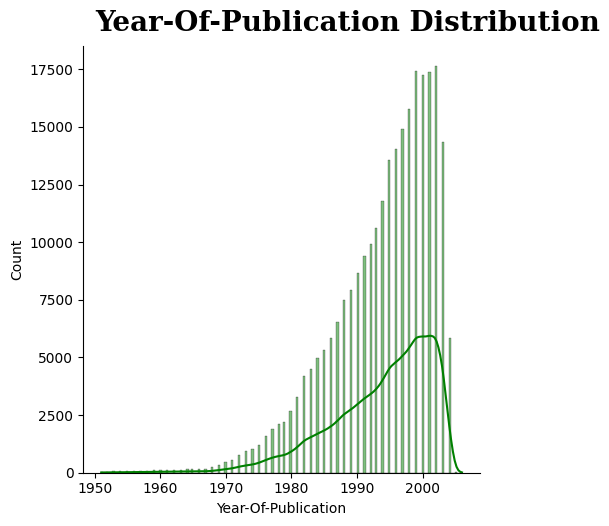

In [21]:
df_books = df_books[df_books['Year-Of-Publication'] > 1950]
df_books = df_books[df_books['Year-Of-Publication'] < 2007]

plot_distribution('Year-Of-Publication', df_books)

## Preprocesamiento

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import estimator_html_repr

import joblib
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, optimizers, callbacks

In [23]:
df_merging= df_ratings.merge(df_users, how='left').merge(df_books, how='left')
df_merging.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,NaN,NaN,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,NaN,NaN,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,"h, new south wales, australia",16.0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


In [24]:
X_item = df_merging[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
X_user = df_merging[['Age', 'Location']]
y = df_merging[['Book-Rating']]

X_item.shape, X_user.shape, y.shape

((1149780, 4), (1149780, 2), (1149780, 1))

In [25]:
def get_2d_to_1d(df):
    return df.reshape(-1)

impute_blanks = lambda: SimpleImputer(strategy='constant', fill_value='')
impute_median = lambda: SimpleImputer(strategy='median')

reshape = lambda: FunctionTransformer(get_2d_to_1d)

tfidf = lambda: TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
scale = lambda: StandardScaler()

preprocessor_items = ColumnTransformer([
    ('Book-Title', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Book-Title']),
    ('Book-Author', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Book-Author']),
    ('Year-Of-Publication', Pipeline([('impute', impute_median()), ('encoder', scale())]), ['Year-Of-Publication']),
    ('Publisher', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Publisher']),
])

preprocessor_users = ColumnTransformer([
    ('Location', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Location']),
    ('Age', Pipeline([('impute', impute_median()), ('encoder', scale())]), ['Age']),
])

ratings_scaler = MinMaxScaler()

x_item = preprocessor_items.fit_transform(X_item)
x_user = preprocessor_users.fit_transform(X_user)
y = ratings_scaler.fit_transform(y).reshape(-1)



In [26]:
HTML(estimator_html_repr(preprocessor_items))

In [27]:
HTML(estimator_html_repr(preprocessor_users))

In [28]:
def sparse_array_conversion(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [29]:
x_item = sparse_array_conversion(x_item)
x_user = sparse_array_conversion(x_user)

## Modelo

In [30]:
items_input = layers.Input(shape=(x_item.shape[1]))
items_ = layers.Dense(32, activation='relu')(items_input)
items_vector = layers.Dense(32, activation='relu')(items_)

users_input = layers.Input(shape=(x_user.shape[1]))
users_ = layers.Dense(32, activation='relu')(users_input)
users_vector = layers.Dense(32, activation='relu')(users_)

items_norm = tf.linalg.l2_normalize(items_vector, axis=1)
users_norm = tf.linalg.l2_normalize(users_vector, axis=1)

output = layers.Dot(axes=1)([items_norm, users_norm])

model = models.Model([items_input, users_input], output)

In [31]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5495)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1538)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           175872      ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 32)           49248       ['input_2[0][0]']                
                                                                                              

In [32]:
model.fit([x_item, x_user], y, epochs=5)

Epoch 1/5
35931/35931 [==============================] - 113s 3ms/step - loss: 0.1331
Epoch 2/5
35931/35931 [==============================] - 108s 3ms/step - loss: 0.1272
Epoch 3/5
35931/35931 [==============================] - 108s 3ms/step - loss: 0.1248
Epoch 4/5
35931/35931 [==============================] - 110s 3ms/step - loss: 0.1231
Epoch 5/5
35931/35931 [==============================] - 110s 3ms/step - loss: 0.1218


In [33]:
model_items = models.Model(items_input, items_vector)
model_users = models.Model(users_input, users_vector)

joblib.dump(preprocessor_items, './models_content/preprocessor_items.bin')
joblib.dump(preprocessor_users, './models_content/preprocessor_users.bin')

model_items.save('./models_content/model_items.h5')
model_users.save('./models_content/model_users.h5')
model.save('./models_content/model.h5')

In [34]:
input_items_vec = layers.Input(shape=(32))
norm_items = tf.linalg.l2_normalize(input_items_vec, axis=1)
input_users_vec = layers.Input(shape=(32))
norm_users = tf.linalg.l2_normalize(input_users_vec, axis=1)
output = layers.Dot(axes=1)([norm_items, norm_users])
dot_model = models.Model([input_items_vec, input_users_vec], output)
dot_model.save('./models_content/dot_model.h5')

## Obteniendo recomendaciones

In [35]:
new_user = pd.DataFrame({'Location': ['barcelona, spain'], 'Age': [25]})
new_user_preprocessed = preprocessor_users.transform(new_user)
new_user_vector = model_users.predict(new_user_preprocessed)
new_user_vector.shape


1/1 [==============================] - 0s 123ms/step


(1, 32)

In [36]:
all_item_preprocessed = preprocessor_items.transform(df_books[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']])
all_item_vector = model_items.predict(all_item_preprocessed)
all_item_vector.shape

8325/8325 [==============================] - 12s 1ms/step


(266391, 32)

In [37]:
new_user_vector = np.broadcast_to(new_user_vector, all_item_vector.shape)
preds = dot_model.predict([new_user_vector, all_item_vector])
df_books['preds'] = preds

8325/8325 [==============================] - 8s 939us/step


In [38]:
df_books.sort_values('preds', ascending=False).head(10)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,preds
239452,2259191630,EbÃ?Â¨ne. Aventures africaines,Ryszard Kapuscinski,2000,Omnibus,http://images.amazon.com/images/P/2259191630.0...,http://images.amazon.com/images/P/2259191630.0...,http://images.amazon.com/images/P/2259191630.0...,0.828101
227007,3423129441,SÃ?Â¤mtliche Werke. Zweisprachige Ausgabe: Fra...,Francois Villon,2002,Dtv,http://images.amazon.com/images/P/3423129441.0...,http://images.amazon.com/images/P/3423129441.0...,http://images.amazon.com/images/P/3423129441.0...,0.759942
28324,2203001143,Tintin Au Pays de L'Or Noir / Land of Black Go...,Herge,1999,Distribooks Intl,http://images.amazon.com/images/P/2203001143.0...,http://images.amazon.com/images/P/2203001143.0...,http://images.amazon.com/images/P/2203001143.0...,0.756550
55611,848328006X,1984,George Orwell,1997,"Plaza &amp; Janes Editores, S.A.",http://images.amazon.com/images/P/848328006X.0...,http://images.amazon.com/images/P/848328006X.0...,http://images.amazon.com/images/P/848328006X.0...,0.752664
119923,8483002507,El misteri de BerlÃ­n (ColÂ¨lecciÃ³ clÃ ssica),Jordi Mata,1997,Columna,http://images.amazon.com/images/P/8483002507.0...,http://images.amazon.com/images/P/8483002507.0...,http://images.amazon.com/images/P/8483002507.0...,0.752404
204935,0914610589,Smart Like Me: High School Age Writing from th...,Mark Pawlak,1995,Hanging Loose Press,http://images.amazon.com/images/P/0914610589.0...,http://images.amazon.com/images/P/0914610589.0...,http://images.amazon.com/images/P/0914610589.0...,0.749703
213685,074750797X,Splitting the Atom,Stephen Amidon,1991,Bloomsbury Publishing Plc,http://images.amazon.com/images/P/074750797X.0...,http://images.amazon.com/images/P/074750797X.0...,http://images.amazon.com/images/P/074750797X.0...,0.748659
198270,0756603005,Scooby-Doo! The Essential Guide,Glenn Dakin,2004,DK Publishing Inc,http://images.amazon.com/images/P/0756603005.0...,http://images.amazon.com/images/P/0756603005.0...,http://images.amazon.com/images/P/0756603005.0...,0.741273
167463,207039252X,Anna KarÃ?Â©nine,LÃ?Â©on TolstoÃ?Â¯,1994,Gallimard,http://images.amazon.com/images/P/207039252X.0...,http://images.amazon.com/images/P/207039252X.0...,http://images.amazon.com/images/P/207039252X.0...,0.740827
136016,3551553068,Fantastische Tierwesen Und Wo Sie Zu Finden Si...,J. K. Rowling,2002,Distribooks,http://images.amazon.com/images/P/3551553068.0...,http://images.amazon.com/images/P/3551553068.0...,http://images.amazon.com/images/P/3551553068.0...,0.740751
